<a href="https://colab.research.google.com/github/yingzibu/MOL2AE/blob/main/examples/ADME_SO_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Packages and codes

In [ ]:
! pip install rdkit --quiet
! pip install PyTDC --quiet
! pip install mycolorpy --quiet

!pip install dgllife --quiet
!pip install molvs --quiet

# !pip install dgl==1.1 --quiet # cpu version, usable for calculation

!pip uninstall dgl -y # dgl cuda version for training using gpu
!pip install  dgl -f https://data.dgl.ai/wheels/cu118/repo.html --quiet
!pip install  dglgo -f https://data.dgl.ai/wheels-test/repo.html --quiet

In [5]:

from sklearn.metrics import f1_score, accuracy_score, average_precision_score
from sklearn.metrics import confusion_matrix, roc_auc_score
import math

def get_preds(threshold, probabilities):
    try:
        if probabilities.shape[1] == 2: probabilities = probabilities[:, 1]
    except: pass
    return [1 if prob > threshold else 0 for prob in probabilities]

def evaluate_model(TP, FP, TN, FN):

    ACCURACY = (TP + TN) / (TP+FP+TN+FN)
    SE = TP/(TP+FN)
    recall = SE
    SP = TN/(TN+FP)
    weighted_accuracy = (SE + SP) / 2

    precision = TP / (TP + FP)
    SP = TN/(TN+FP)
    F1 = 2 * precision * recall /(precision + recall)

    temp = (TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)
    if temp != 0:
        MCC = (TP*TN-FP*FN)*1.0/(math.sqrt(temp))
    else:
        print('equation for MCC is (TP*TN-FP*FN)*1.0/(math.sqrt(temp))')
        print('TP, FP, TN, FN', TP, FP, TN, FN)
        print('temp=0')
        MCC = 'N/A'

    return ACCURACY,SE, SP, weighted_accuracy, precision, F1, MCC

def evaluate(y_real, y_hat, y_prob):
    TN, FP, FN, TP = confusion_matrix(y_real, y_hat).ravel()
    ACCURACY,SE, SP, weighted_accuracy, precision, F1, \
        MCC  = evaluate_model(TP, FP, TN, FN)
    try:
        if y_prob.shape[1] == 2: proba = y_prob[:, 1]
        else: proba = y_prob
    except: proba = y_prob
    AP = average_precision_score(y_real, proba)
    AUC = roc_auc_score(y_real, proba)
    print('Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP')
    if MCC != 'N/A':
        print("& %5.3f" % (ACCURACY), " &%7.3f" % (weighted_accuracy), " &%15.3f" % (precision),
      " &%10.3f" % (SE), " &%5.3f" % (SP), " &%5.3f" % (F1), "&%5.3f" % (AUC),
      "&%8.3f" % (MCC), "&%8.3f" % (AP))
    else:
        print("& %5.3f" % (ACCURACY), " &%7.3f" % (weighted_accuracy), " &%15.3f" % (precision),
      " &%10.3f" % (SE), " &%5.3f" % (SP), " &%5.3f" % (F1), "&%5.3f" % (AUC), "& ",
        MCC, "&%8.3f" % (AP))

    return ACCURACY, weighted_accuracy, precision, SE, SP, F1, AUC, MCC, AP

In [6]:
from rdkit import Chem
from rdkit.Chem.SaltRemover import SaltRemover
import pandas as pd
import numpy as np
from tqdm import tqdm
"Reference: https://github.com/Yimeng-Wang/JAK-MTATFP/blob/main/preprocess.py"

from molvs.normalize import Normalizer, Normalization
from molvs.charge import Reionizer, Uncharger
import torch.nn as nn

from tdc.single_pred import ADME
from rdkit import RDLogger
import warnings
RDLogger.DisableLog('rdApp.*')
warnings.filterwarnings("ignore")
MASK = -100


def preprocess(smi):
    mol = Chem.MolFromSmiles(smi)
    normalizer = Normalizer()
    new1 = normalizer.normalize(mol)
    remover = SaltRemover()
    new2 = remover(new1)
    neutralize1 = Reionizer()
    new3 = neutralize1(new2)
    neutralize2 = Uncharger()
    new4 = neutralize2(new3)
    new_smiles = Chem.MolToSmiles(new4, kekuleSmiles=False)
    return new_smiles

Mod

In [7]:
from torch.utils.data import DataLoader, Dataset

import pandas as pd
import rdkit
from rdkit import Chem
from rdkit.Chem.MACCSkeys import GenMACCSKeys
import torch.nn.functional as F

m = Chem.MolFromSmiles
header = ['bit' + str(i) for i in range(167)]

def smile_list_to_MACCS(smi_list:list):
    MACCS_list = []
    for smi in smi_list:
        maccs = [float(i) for i in list(GenMACCSKeys(m(smi)).ToBitString())]
        MACCS_list.append(maccs)
    return MACCS_list

In [8]:
import torch
def process(data):

    # data = convert_with_qed_sa(data)
    print('---> converting SMILES to MACCS...')
    MACCS_list = smile_list_to_MACCS(data['Drug'].tolist())
    data[header] = pd.DataFrame(MACCS_list)
    print('---> FINISHED')
    return data

MASK = -100

class nn_dataset(Dataset):
    def __init__(self, df, prop_names, mask=MASK):
        super(nn_dataset, self).__init__()
        df = process(df)
        df = df.fillna(mask)
        self.df = df
        self.len = len(df)
        self.fp = self.df[header]
        if isinstance(prop_names, str): prop_names = [prop_names]
        self.props = self.df[prop_names]

    def __getitem__(self, idx):
        fp = torch.tensor(self.fp.iloc[idx], dtype=torch.float32)
        label = torch.tensor(self.props.iloc[idx], dtype=torch.float32)
        return fp, label

    def __len__(self): return self.len

    def get_df(self): return self.df

In [9]:
def rename_cols(df, name): return df.rename(columns={'Y':name})

def clean_mol(df:pd.DataFrame):
    prev_len = len(df)
    for i in tqdm(range(len(df)), total=len(df), desc='Cleaning mols'):
        try: df.iloc[i]['Drug'] = preprocess(df.iloc[i]['Drug'])
        except: df.drop(i)
    if len(df) != prev_len: print(f'prev len: {prev_len}; after clean: {len(df)}')
    return df.reset_index(drop=True)

In [26]:
# data = ADME(name = name)
tox_reg = ['LD50_Zhu'] + label_list[:2]
tox_cls = ['hERG', 'hERG_Karim', 'AMES'] + [label_list[2]]
tox_all = tox_reg + tox_cls

def get_tvt(name, data=None, display_distribution=False):
    """
    clean and get train valid and test
    param data: data format in TDC
    return train, valid, test as pd.DataFrame
    """
    print()
    print('*'*25, name, '*'* 25)
    print()
    if name in label_list: data = Tox(name='herg_central', label_name=name)
    elif name in tox_all: data = Tox(name=name)
    else: data = ADME(name=name)

    if display_distribution:  data.label_distribution()
    split = data.get_split()
    train, valid = clean_mol(split['train']), clean_mol(split['valid'])
    test =  clean_mol(split['test'])
    train = rename_cols(train[['Drug', 'Y']], name)
    valid = rename_cols(valid[['Drug', 'Y']], name)
    test  = rename_cols(test[['Drug', 'Y']],  name)
    return train, valid, test



In [35]:

class Classifier(nn.Module):
    def __init__(self, dims):
        super(Classifier, self).__init__()
        [in_dim, h_dims, out_dim] = dims
        self.dims = dims
        neurons = [in_dim, *h_dims]
        linear_layers = [nn.Linear(neurons[i-1], neurons[i]) \
                         for i in range(1, len(neurons))]
        self.hidden = nn.ModuleList(linear_layers)
        self.final = nn.Linear(h_dims[-1], out_dim)

    def forward(self, x):
        for layer in self.hidden:
            x = F.relu(layer(x))
        x = self.final(x)
        return x

    def get_dim(self): return self.dims


In [34]:

import matplotlib.pyplot as plt

def get_min(d:dict):
    min_key = next(iter(d))

    # Iterate over the keys in the dictionary
    for key in d:
        # If the value of the current key > the value of max_key, update max_key
        if d[key] < d[min_key]:
            min_key = key
    return min_key, d[min_key]

def plot_loss(train_dict, test_dict, name='test'):
    fig = plt.figure()
    plt.plot(list(train_dict.keys()), list(train_dict.values()), label='train')
    plt.plot(list(test_dict.keys()), list(test_dict.values()), label=name)
    argmin, min = get_min(test_dict)
    plt.plot(argmin, min, '*', label=f'min epoch {argmin}')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('loss during training')
    plt.legend()
    plt.show()



In [29]:
##################
name_reg = ['Half_Life_Obach', 'Clearance_Hepatocyte_AZ', 'VDss_Lombardo',
         'PPBR_AZ', 'Caco2_Wang', 'Lipophilicity_AstraZeneca',
         'HydrationFreeEnergy_FreeSolv', 'Solubility_AqSolDB']
name_reg = name_reg[4:]
name_cls = ['BBB_Martins', 'Bioavailability_Ma', 'Pgp_Broccatelli',
             'HIA_Hou', 'PAMPA_NCATS', 'CYP2C19_Veith', 'CYP2D6_Veith',
            'CYP3A4_Veith', 'CYP1A2_Veith', 'CYP2C9_Veith']

name = name_cls[0]


from tdc.single_pred import Tox
from tdc.utils import retrieve_label_name_list
label_list = retrieve_label_name_list('herg_central')
tox_reg = ['LD50_Zhu'] + label_list[:2]
tox_cls = ['hERG', 'hERG_Karim', 'AMES'] + [label_list[2]]
tox_all = tox_reg + tox_cls

In [51]:
if name in name_reg: IS_R = True
else: IS_R = False

names = [name]
if IS_R: loss_function = nn.MSELoss(reduction='sum'); loss_label = 'MSE'
else: loss_function = nn.BCEWithLogitsLoss(reduction='sum'); loss_label = 'BCE'
print('Is a regression task? ', IS_R, f'--> Use {loss_label} loss')

batch_size = 64

params_nn = {'batch_size': batch_size, 'shuffle': True,
          'drop_last': False, 'num_workers': 0}

trains, valids, tests = get_tvt(name)
train_loader_nn = DataLoader(nn_dataset(trains, names), **params_nn)
valid_loader_nn = DataLoader(nn_dataset(valids, names), **params_nn)
test_loader_nn  = DataLoader(nn_dataset(tests,  names), **params_nn)


Downloading...


************************* BBB_Martins *************************


100%|██████████| 138k/138k [00:00<00:00, 206kiB/s] 
Loading...
Done!
Cleaning mols: 100%|██████████| 406/406 [00:01<00:00, 398.91it/s]


---> converting SMILES to MACCS...
---> FINISHED
---> converting SMILES to MACCS...
---> FINISHED
---> converting SMILES to MACCS...
---> FINISHED


In [53]:
in_dim = 167 # len of fingerprint
out_dim = len(names)
hid_dims = [128, 64, 32, 16] # hidden dims changeable

dims = [in_dim, hid_dims, out_dim]
print(dims)

model = Classifier(dims)


cuda = torch.cuda.is_available()

if cuda: model = model.cuda(); device = 'cuda'
else: device = 'cpu'
from torchsummary import summary
summary(model, (batch_size, in_dim))

lr = 3e-4
wd = 1e-5
train_loss_dict = {}
valid_loss_dict = {}

epochs = 1000
best_epoch = 0

optimizer = torch.optim.AdamW(params=model.parameters(), lr=lr, weight_decay=wd)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 64, 128]          21,504
            Linear-2               [-1, 64, 64]           8,256
            Linear-3               [-1, 64, 32]           2,080
            Linear-4               [-1, 64, 16]             528
            Linear-5                [-1, 64, 1]              17
Total params: 32,385
Trainable params: 32,385
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.04
Forward/backward pass size (MB): 0.12
Params size (MB): 0.12
Estimated Total Size (MB): 0.28
----------------------------------------------------------------


Epoch 0: [Train] BCE loss: 0.692 [Valid] BCE loss: 0.680
Epoch 5: [Train] BCE loss: 0.451 [Valid] BCE loss: 0.431
Epoch 10: [Train] BCE loss: 0.319 [Valid] BCE loss: 0.305
Epoch 15: [Train] BCE loss: 0.249 [Valid] BCE loss: 0.289
Epoch 20: [Train] BCE loss: 0.202 [Valid] BCE loss: 0.305
Epoch 25: [Train] BCE loss: 0.164 [Valid] BCE loss: 0.337
Epoch 30: [Train] BCE loss: 0.125 [Valid] BCE loss: 0.382
loss increase


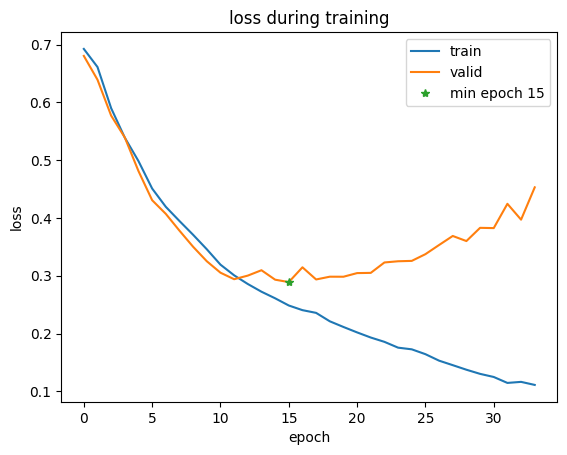

In [54]:

if best_epoch != 0: model.load_state_dict(torch.load('ckpt_nn.pt', map_location=device))

for epoch in range(best_epoch, epochs + best_epoch):
    total_loss = 0
    model.train()
    for fp, label in train_loader_nn:
        optimizer.zero_grad()
        if cuda: fp, label = fp.cuda(), label.cuda()
        mask = label == MASK
        output = model(fp)
        loss = loss_function(output[~mask], label[~mask])
        loss.backward(); optimizer.step()
        total_loss += loss.item()
    total_loss /= len(train_loader_nn.dataset)
    train_loss_dict[epoch] = total_loss

    model.eval()
    total_valid_loss = 0
    for fp, label in valid_loader_nn:
        if cuda: fp, label = fp.cuda(), label.cuda()
        mask = label == MASK
        output = model(fp)
        loss = loss_function(output[~mask], label[~mask])
        total_valid_loss += loss.item()
    total_valid_loss /= len(valid_loader_nn.dataset)
    if epoch % 5 == 0:
        print(f'Epoch {epoch}: [Train] {loss_label} loss: {total_loss:.3f}',
              f'[Valid] {loss_label} loss: {total_valid_loss:.3f}')
    try: argmin, min_loss = get_min(valid_loss_dict)
    except: argmin, min_loss = -1, 10000
    if total_valid_loss <= min_loss and epoch > 3:
        # print('Save model at epoch', epoch)
        torch.save(model.state_dict(), 'ckpt_nn.pt')
        best_epoch = epoch

    valid_loss_dict[epoch] = total_valid_loss

    if epoch - argmin > 20: print('early stop, no decrease'); break
    if total_valid_loss / min_loss > 1.5: print('loss increase'); break

    # if epoch % 10 == 0 and epoch != 0:
plot_loss(train_loss_dict, valid_loss_dict, name='valid')

In [33]:

from mycolorpy import colorlist as mcp
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

def reg_evaluate(label_clean, preds_clean):
    mae = metrics.mean_absolute_error(label_clean, preds_clean)
    mse = metrics.mean_squared_error(label_clean, preds_clean)
    rmse = np.sqrt(mse) #mse**(0.5)
    r2 = metrics.r2_score(label_clean, preds_clean)

    print('MAE     RMSE     R2')
    print("& %5.3f" % (mae), " & %3.3f" % (rmse), " & %3.3f" % (r2))

    eval_result_r2 =   f'R2:     {r2:.3f}'
    eval_result_mae =  f'MAE:   {mae:.3f}'
    eval_result_rmse = f'RMSE: {rmse:.3f}'

    return eval_result_r2, eval_result_mae, eval_result_rmse

Evaluate on test sets
using BCELOSSwithdigits


In [57]:
model.load_state_dict(torch.load('ckpt_nn.pt', map_location=device))
print('Evaluate on test sets')
model = model.cpu()
model.eval()

if IS_R: print('using MSELoss')
else: print('using BCELOSSwithdigits')

total_loss = 0
for i, (fp, label) in enumerate(test_loader_nn):
    # if cuda: fp, label = fp.cuda(), label.cuda()
    mask = label == MASK
    output = model(fp)
    loss = loss_function(output[~mask], label[~mask])
    total_loss += loss.item()
    if i == 0:
        preds_ = output.cpu()
        labels_ = label.cpu()
        masks_ = mask.cpu()
    else:
        preds_ = torch.cat([preds_, output.cpu()], dim=0)
        labels_ = torch.cat([labels_, label.cpu()], dim=0)
        masks_ = torch.cat([masks_, mask.cpu()], dim=0)
total_loss /= len(test_loader_nn.dataset)
print(f'total_loss: {total_loss:.3f}')

total_loss: 0.375


In [61]:

for i, name in enumerate(names):
    try: name = name.split('_')[0]
    except: pass
    print('*'*15, name, '*'*15)

    if IS_R:
        r2, mae, rmse = reg_evaluate(
                        labels_[:, i][~masks_[:, i]].detach().numpy(),
                        preds_[:, i][~masks_[:, i]].detach().numpy())

        color = mcp.gen_color_normalized(cmap='viridis',
                    data_arr=labels_[:, i][~masks_[:, i]].detach().numpy())
        plt.scatter(labels_[:, i][~masks_[:, i]].detach().numpy(),
                    preds_[:, i][~masks_[:, i]].detach().numpy(),
                    cmap='viridis', marker='.',
                    s=10, alpha=0.5, edgecolors='none', c=color)
        plt.xlabel(f'True {name}')
        plt.ylabel(f'Predicted {name}')
        plt.title(f'{name} prediction on test set using SO NN FP')
        x0, xmax = plt.xlim()
        y0, ymax = plt.ylim()
        data_width = xmax - x0
        data_height = ymax - y0
        # print(x0, xmax, y0, ymax, data_width, data_height)
        plt.text(x0 + 0.1*data_width, y0 + data_height * 0.8/0.95, r2)
        plt.text(x0 + 0.1*data_width, y0 + data_height * 0.8,  mae)
        plt.text(x0 + 0.1*data_width, y0 + data_height * 0.8*0.95, rmse)

        plt.show()
        plt.cla()
        plt.clf()
        plt.close()

    else:
        probs = F.sigmoid(preds_[:, i][~masks_[:, i]])
        label = labels_[:, i][~masks_[:, i]]
        probs = probs.cpu().detach().numpy()
        label = label.cpu().detach().numpy()
        assert len(probs) == len(label)
        preds = get_preds(0.5, probs)
        evaluate(label, preds, probs)
        print()


*************** BBB ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.847  &  0.750  &          0.862  &     0.947  &0.553  &0.903 &0.876 &   0.567 &   0.946



In [28]:

def single_train(name):

    if name in name_reg + tox_reg: IS_R = True
    else: IS_R = False

    names = [name]
    if IS_R: loss_function = nn.MSELoss(reduction='sum'); loss_label = 'MSE'
    else: loss_function = nn.BCEWithLogitsLoss(reduction='sum'); loss_label = 'BCE'
    print('Is a regression task? ', IS_R, f'--> Use {loss_label} loss')

    batch_size = 64

    params_nn = {'batch_size': batch_size, 'shuffle': True,
            'drop_last': False, 'num_workers': 0}

    trains, valids, tests = get_tvt(name)
    train_loader_nn = DataLoader(nn_dataset(trains, names), **params_nn)
    valid_loader_nn = DataLoader(nn_dataset(valids, names), **params_nn)
    test_loader_nn  = DataLoader(nn_dataset(tests,  names), **params_nn)

    # GET MODEL
    in_dim = 167 # len of fingerprint
    out_dim = len(names)
    hid_dims = [128, 64, 32, 16] # hidden dims changeable
    dims = [in_dim, hid_dims, out_dim]
    model = Classifier(dims)
    cuda = torch.cuda.is_available()
    if cuda: model = model.cuda(); device = 'cuda'
    else: device = 'cpu'
    lr = 3e-4
    wd = 1e-5
    train_loss_dict = {}
    valid_loss_dict = {}

    epochs = 1000
    best_epoch = 0

    optimizer = torch.optim.AdamW(params=model.parameters(), lr=lr, weight_decay=wd)

    for epoch in range(best_epoch, epochs + best_epoch):
        total_loss = 0
        model.train()
        for fp, label in train_loader_nn:
            optimizer.zero_grad()
            if cuda: fp, label = fp.cuda(), label.cuda()
            mask = label == MASK
            output = model(fp)
            loss = loss_function(output[~mask], label[~mask])
            loss.backward(); optimizer.step()
            total_loss += loss.item()
        total_loss /= len(train_loader_nn.dataset)
        train_loss_dict[epoch] = total_loss

        model.eval()
        total_valid_loss = 0
        for fp, label in valid_loader_nn:
            if cuda: fp, label = fp.cuda(), label.cuda()
            mask = label == MASK
            output = model(fp)
            loss = loss_function(output[~mask], label[~mask])
            total_valid_loss += loss.item()
        total_valid_loss /= len(valid_loader_nn.dataset)
        if epoch % 5 == 0:
            print(f'Epoch {epoch}: [Train] {loss_label} loss: {total_loss:.3f}',
                f'[Valid] {loss_label} loss: {total_valid_loss:.3f}')
        try: argmin, min_loss = get_min(valid_loss_dict)
        except: argmin, min_loss = -1, 10000
        if total_valid_loss <= min_loss and epoch > 3:
            # print('Save model at epoch', epoch)
            torch.save(model.state_dict(), 'ckpt_nn.pt')
            best_epoch = epoch

        valid_loss_dict[epoch] = total_valid_loss

        if epoch - argmin > 20: print('early stop, no decrease'); break
        if total_valid_loss / min_loss > 1.5: print('loss increase'); break

        # if epoch % 10 == 0 and epoch != 0:
    plot_loss(train_loss_dict, valid_loss_dict, name='valid')

    model.load_state_dict(torch.load('ckpt_nn.pt', map_location=device))
    print('Evaluate on test sets')
    model = model.cpu()
    model.eval()

    if IS_R: print('using MSELoss')
    else: print('using BCELOSSwithdigits')

    total_loss = 0
    for i, (fp, label) in enumerate(test_loader_nn):
        # if cuda: fp, label = fp.cuda(), label.cuda()
        mask = label == MASK
        output = model(fp)
        loss = loss_function(output[~mask], label[~mask])
        total_loss += loss.item()
        if i == 0:
            preds_ = output.cpu()
            labels_ = label.cpu()
            masks_ = mask.cpu()
        else:
            preds_ = torch.cat([preds_, output.cpu()], dim=0)
            labels_ = torch.cat([labels_, label.cpu()], dim=0)
            masks_ = torch.cat([masks_, mask.cpu()], dim=0)
    total_loss /= len(test_loader_nn.dataset)
    print(f'total_loss: {total_loss:.3f}')


    for i, name in enumerate(names):
        try: name = name.split('_')[0]
        except: pass
        print('*'*15, name, '*'*15)

        if IS_R:
            r2, mae, rmse = reg_evaluate(
                            labels_[:, i][~masks_[:, i]].detach().numpy(),
                            preds_[:, i][~masks_[:, i]].detach().numpy())

            color = mcp.gen_color_normalized(cmap='viridis',
                        data_arr=labels_[:, i][~masks_[:, i]].detach().numpy())
            plt.scatter(labels_[:, i][~masks_[:, i]].detach().numpy(),
                        preds_[:, i][~masks_[:, i]].detach().numpy(),
                        cmap='viridis', marker='.',
                        s=10, alpha=0.5, edgecolors='none', c=color)
            plt.xlabel(f'True {name}')
            plt.ylabel(f'Predicted {name}')
            plt.title(f'{name} prediction on test set using SO NN FP')
            x0, xmax = plt.xlim()
            y0, ymax = plt.ylim()
            data_width = xmax - x0
            data_height = ymax - y0
            # print(x0, xmax, y0, ymax, data_width, data_height)
            plt.text(x0 + 0.1*data_width, y0 + data_height * 0.8/0.95, r2)
            plt.text(x0 + 0.1*data_width, y0 + data_height * 0.8,  mae)
            plt.text(x0 + 0.1*data_width, y0 + data_height * 0.8*0.95, rmse)

            plt.show()
            plt.cla()
            plt.clf()
            plt.close()

        else:
            probs = F.sigmoid(preds_[:, i][~masks_[:, i]])
            label = labels_[:, i][~masks_[:, i]]
            probs = probs.cpu().detach().numpy()
            label = label.cpu().detach().numpy()
            assert len(probs) == len(label)
            preds = get_preds(0.5, probs)
            evaluate(label, preds, probs)
            print()


Found local copy...
Loading...
Done!


Is a regression task?  True --> Use MSE loss
************************* Caco2_Wang *************************


Cleaning mols: 100%|██████████| 182/182 [00:00<00:00, 378.47it/s]


---> converting SMILES to MACCS...
---> FINISHED
---> converting SMILES to MACCS...
---> FINISHED
---> converting SMILES to MACCS...
---> FINISHED
Epoch 0: [Train] MSE loss: 28.818 [Valid] MSE loss: 27.244
Epoch 5: [Train] MSE loss: 7.310 [Valid] MSE loss: 3.740
Epoch 10: [Train] MSE loss: 2.058 [Valid] MSE loss: 2.069
Epoch 15: [Train] MSE loss: 1.448 [Valid] MSE loss: 1.627
Epoch 20: [Train] MSE loss: 0.931 [Valid] MSE loss: 1.189
Epoch 25: [Train] MSE loss: 0.579 [Valid] MSE loss: 0.822
Epoch 30: [Train] MSE loss: 0.403 [Valid] MSE loss: 0.607
Epoch 35: [Train] MSE loss: 0.306 [Valid] MSE loss: 0.468
Epoch 40: [Train] MSE loss: 0.250 [Valid] MSE loss: 0.385
Epoch 45: [Train] MSE loss: 0.219 [Valid] MSE loss: 0.349
Epoch 50: [Train] MSE loss: 0.193 [Valid] MSE loss: 0.310
Epoch 55: [Train] MSE loss: 0.177 [Valid] MSE loss: 0.288
Epoch 60: [Train] MSE loss: 0.161 [Valid] MSE loss: 0.268
Epoch 65: [Train] MSE loss: 0.148 [Valid] MSE loss: 0.256
Epoch 70: [Train] MSE loss: 0.137 [Valid]

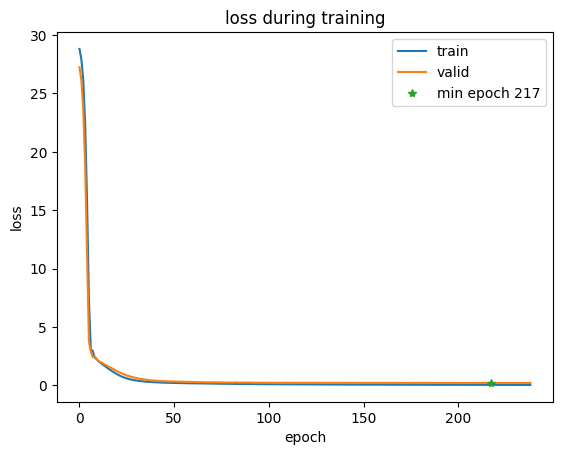

Evaluate on test sets
using MSELoss
total_loss: 0.234
*************** Caco2 ***************
MAE     RMSE     R2
& 0.356  & 0.484  & 0.632


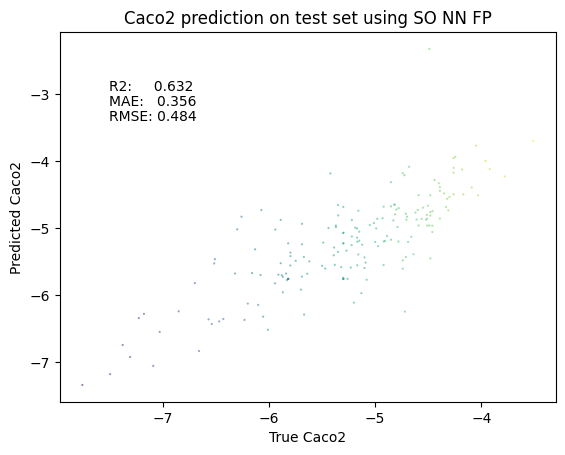

Downloading...


Is a regression task?  True --> Use MSE loss
************************* Lipophilicity_AstraZeneca *************************


100%|██████████| 298k/298k [00:00<00:00, 321kiB/s]
Loading...
Done!
Cleaning mols: 100%|██████████| 840/840 [00:02<00:00, 368.27it/s]


---> converting SMILES to MACCS...
---> FINISHED
---> converting SMILES to MACCS...
---> FINISHED
---> converting SMILES to MACCS...
---> FINISHED
Epoch 0: [Train] MSE loss: 5.827 [Valid] MSE loss: 5.092
Epoch 5: [Train] MSE loss: 1.314 [Valid] MSE loss: 1.221
Epoch 10: [Train] MSE loss: 0.983 [Valid] MSE loss: 0.968
Epoch 15: [Train] MSE loss: 0.840 [Valid] MSE loss: 0.895
Epoch 20: [Train] MSE loss: 0.744 [Valid] MSE loss: 0.862
Epoch 25: [Train] MSE loss: 0.655 [Valid] MSE loss: 0.826
Epoch 30: [Train] MSE loss: 0.558 [Valid] MSE loss: 0.778
Epoch 35: [Train] MSE loss: 0.486 [Valid] MSE loss: 0.749
Epoch 40: [Train] MSE loss: 0.427 [Valid] MSE loss: 0.722
Epoch 45: [Train] MSE loss: 0.380 [Valid] MSE loss: 0.698
Epoch 50: [Train] MSE loss: 0.333 [Valid] MSE loss: 0.698
Epoch 55: [Train] MSE loss: 0.295 [Valid] MSE loss: 0.696
Epoch 60: [Train] MSE loss: 0.279 [Valid] MSE loss: 0.687
Epoch 65: [Train] MSE loss: 0.249 [Valid] MSE loss: 0.726
Epoch 70: [Train] MSE loss: 0.221 [Valid] M

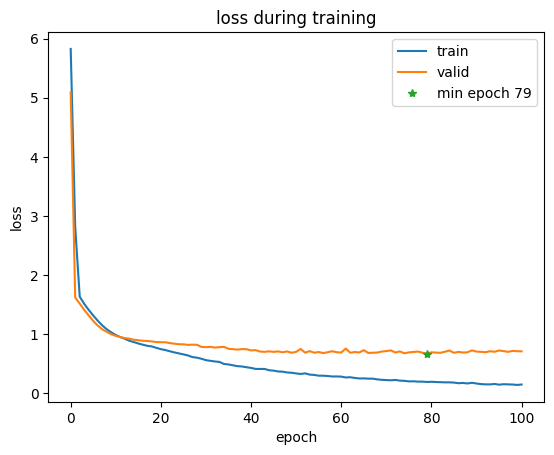

Evaluate on test sets
using MSELoss
total_loss: 0.780
*************** Lipophilicity ***************
MAE     RMSE     R2
& 0.657  & 0.883  & 0.472


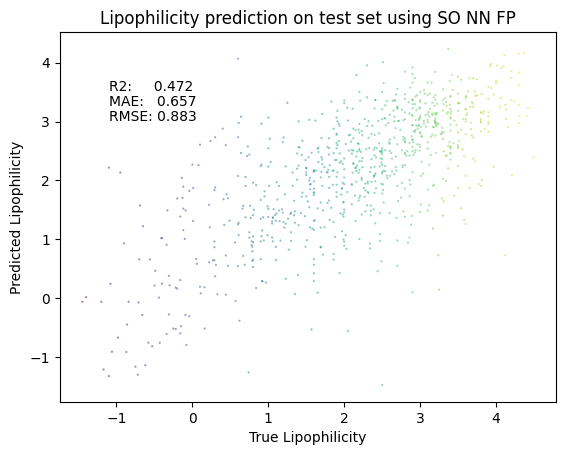

Downloading...


Is a regression task?  True --> Use MSE loss
************************* HydrationFreeEnergy_FreeSolv *************************


100%|██████████| 29.0k/29.0k [00:00<00:00, 30.0MiB/s]
Loading...
Done!
Cleaning mols: 100%|██████████| 128/128 [00:00<00:00, 547.70it/s]


---> converting SMILES to MACCS...
---> FINISHED
---> converting SMILES to MACCS...
---> FINISHED
---> converting SMILES to MACCS...
---> FINISHED
Epoch 0: [Train] MSE loss: 28.948 [Valid] MSE loss: 29.158
Epoch 5: [Train] MSE loss: 27.002 [Valid] MSE loss: 26.259
Epoch 10: [Train] MSE loss: 12.576 [Valid] MSE loss: 8.081
Epoch 15: [Train] MSE loss: 6.030 [Valid] MSE loss: 5.675
Epoch 20: [Train] MSE loss: 3.875 [Valid] MSE loss: 5.213
Epoch 25: [Train] MSE loss: 2.681 [Valid] MSE loss: 4.479
Epoch 30: [Train] MSE loss: 2.101 [Valid] MSE loss: 3.823
Epoch 35: [Train] MSE loss: 1.698 [Valid] MSE loss: 3.145
Epoch 40: [Train] MSE loss: 1.402 [Valid] MSE loss: 2.699
Epoch 45: [Train] MSE loss: 1.128 [Valid] MSE loss: 2.302
Epoch 50: [Train] MSE loss: 0.933 [Valid] MSE loss: 1.967
Epoch 55: [Train] MSE loss: 0.787 [Valid] MSE loss: 1.809
Epoch 60: [Train] MSE loss: 0.665 [Valid] MSE loss: 1.895
Epoch 65: [Train] MSE loss: 0.541 [Valid] MSE loss: 1.567
Epoch 70: [Train] MSE loss: 0.438 [Val

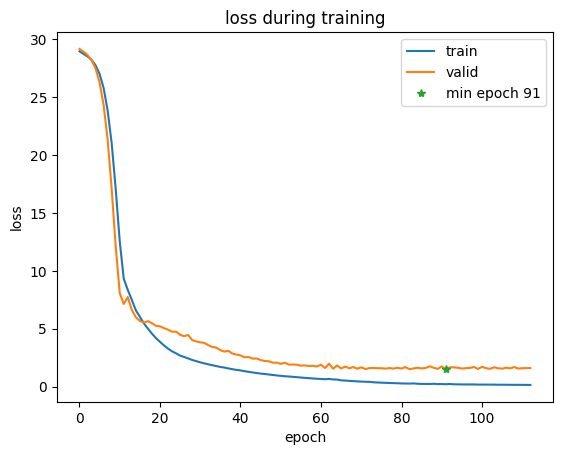

Evaluate on test sets
using MSELoss
total_loss: 1.233
*************** HydrationFreeEnergy ***************
MAE     RMSE     R2
& 0.718  & 1.110  & 0.925


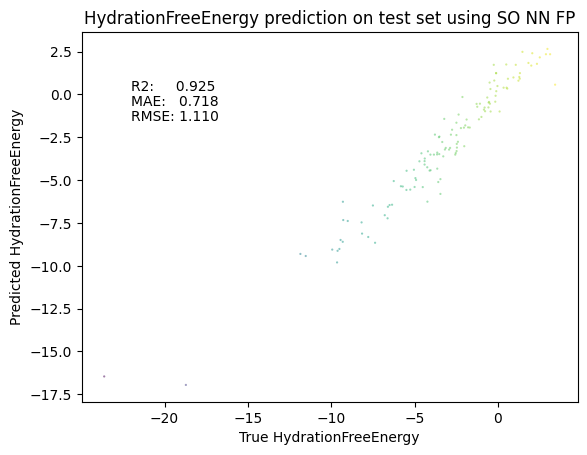

Downloading...


Is a regression task?  True --> Use MSE loss
************************* Solubility_AqSolDB *************************


100%|██████████| 853k/853k [00:01<00:00, 762kiB/s]
Loading...
Done!
Cleaning mols: 100%|██████████| 1996/1996 [00:04<00:00, 447.84it/s]


---> converting SMILES to MACCS...
---> FINISHED
---> converting SMILES to MACCS...
---> FINISHED
---> converting SMILES to MACCS...
---> FINISHED
Epoch 0: [Train] MSE loss: 10.807 [Valid] MSE loss: 5.485
Epoch 5: [Train] MSE loss: 2.052 [Valid] MSE loss: 2.146
Epoch 10: [Train] MSE loss: 1.707 [Valid] MSE loss: 1.974
Epoch 15: [Train] MSE loss: 1.478 [Valid] MSE loss: 1.861
Epoch 20: [Train] MSE loss: 1.305 [Valid] MSE loss: 1.708
Epoch 25: [Train] MSE loss: 1.165 [Valid] MSE loss: 1.720
Epoch 30: [Train] MSE loss: 1.043 [Valid] MSE loss: 1.634
Epoch 35: [Train] MSE loss: 0.953 [Valid] MSE loss: 1.620
Epoch 40: [Train] MSE loss: 0.862 [Valid] MSE loss: 1.618
Epoch 45: [Train] MSE loss: 0.785 [Valid] MSE loss: 1.616
Epoch 50: [Train] MSE loss: 0.721 [Valid] MSE loss: 1.670
Epoch 55: [Train] MSE loss: 0.680 [Valid] MSE loss: 1.616
early stop, no decrease


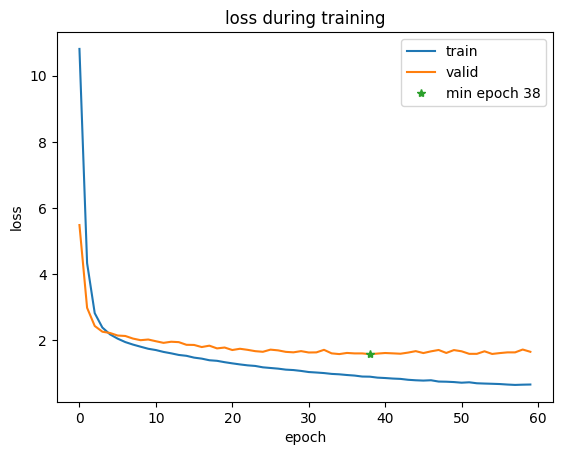

Evaluate on test sets
using MSELoss
total_loss: 1.560
*************** Solubility ***************
MAE     RMSE     R2
& 0.904  & 1.249  & 0.713


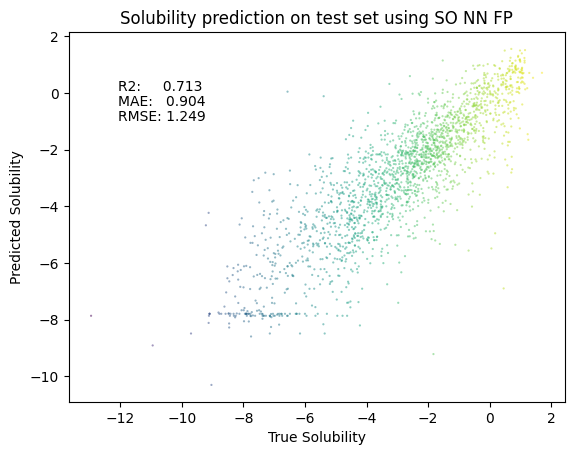

Found local copy...
Loading...
Done!


Is a regression task?  False --> Use BCE loss
************************* BBB_Martins *************************


Cleaning mols: 100%|██████████| 406/406 [00:01<00:00, 397.45it/s]


---> converting SMILES to MACCS...
---> FINISHED
---> converting SMILES to MACCS...
---> FINISHED
---> converting SMILES to MACCS...
---> FINISHED
Epoch 0: [Train] BCE loss: 0.654 [Valid] BCE loss: 0.652
Epoch 5: [Train] BCE loss: 0.431 [Valid] BCE loss: 0.404
Epoch 10: [Train] BCE loss: 0.301 [Valid] BCE loss: 0.293
Epoch 15: [Train] BCE loss: 0.246 [Valid] BCE loss: 0.293
Epoch 20: [Train] BCE loss: 0.202 [Valid] BCE loss: 0.311
Epoch 25: [Train] BCE loss: 0.164 [Valid] BCE loss: 0.338
loss increase


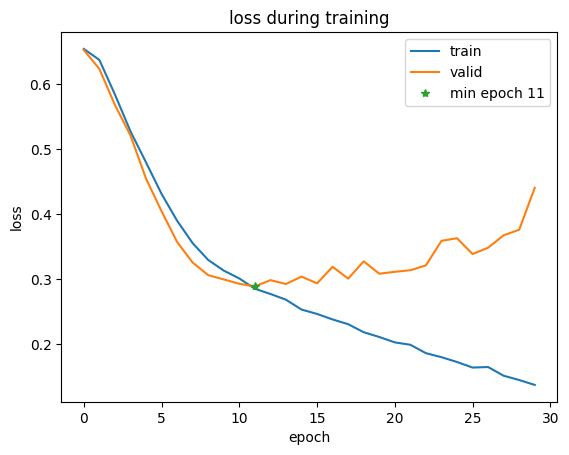

Evaluate on test sets
using BCELOSSwithdigits


Downloading...


total_loss: 0.375
*************** BBB ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.852  &  0.766  &          0.872  &     0.941  &0.592  &0.905 &0.867 &   0.586 &   0.939

Is a regression task?  False --> Use BCE loss
************************* Bioavailability_Ma *************************


100%|██████████| 43.7k/43.7k [00:00<00:00, 188kiB/s]
Loading...
Done!
Cleaning mols: 100%|██████████| 128/128 [00:00<00:00, 397.23it/s]


---> converting SMILES to MACCS...
---> FINISHED
---> converting SMILES to MACCS...
---> FINISHED
---> converting SMILES to MACCS...
---> FINISHED
Epoch 0: [Train] BCE loss: 0.670 [Valid] BCE loss: 0.663
Epoch 5: [Train] BCE loss: 0.595 [Valid] BCE loss: 0.573
Epoch 10: [Train] BCE loss: 0.525 [Valid] BCE loss: 0.510
Epoch 15: [Train] BCE loss: 0.508 [Valid] BCE loss: 0.496
Epoch 20: [Train] BCE loss: 0.488 [Valid] BCE loss: 0.476
Epoch 25: [Train] BCE loss: 0.456 [Valid] BCE loss: 0.453
Epoch 30: [Train] BCE loss: 0.422 [Valid] BCE loss: 0.440
Epoch 35: [Train] BCE loss: 0.382 [Valid] BCE loss: 0.438
Epoch 40: [Train] BCE loss: 0.328 [Valid] BCE loss: 0.461
Epoch 45: [Train] BCE loss: 0.255 [Valid] BCE loss: 0.517
Epoch 50: [Train] BCE loss: 0.193 [Valid] BCE loss: 0.579
early stop, no decrease


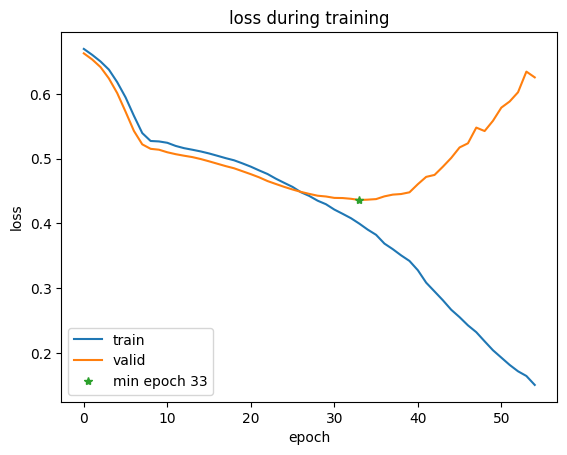

Downloading...


Evaluate on test sets
using BCELOSSwithdigits
total_loss: 0.628
*************** Bioavailability ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.711  &  0.528  &          0.715  &     0.978  &0.079  &0.826 &0.681 &   0.134 &   0.802

Is a regression task?  False --> Use BCE loss
************************* Pgp_Broccatelli *************************


100%|██████████| 126k/126k [00:00<00:00, 282kiB/s] 
Loading...
Done!
Cleaning mols: 100%|██████████| 244/244 [00:00<00:00, 382.03it/s]


---> converting SMILES to MACCS...
---> FINISHED
---> converting SMILES to MACCS...
---> FINISHED
---> converting SMILES to MACCS...
---> FINISHED
Epoch 0: [Train] BCE loss: 0.688 [Valid] BCE loss: 0.686
Epoch 5: [Train] BCE loss: 0.605 [Valid] BCE loss: 0.597
Epoch 10: [Train] BCE loss: 0.398 [Valid] BCE loss: 0.401
Epoch 15: [Train] BCE loss: 0.285 [Valid] BCE loss: 0.345
Epoch 20: [Train] BCE loss: 0.213 [Valid] BCE loss: 0.342
Epoch 25: [Train] BCE loss: 0.174 [Valid] BCE loss: 0.372
Epoch 30: [Train] BCE loss: 0.132 [Valid] BCE loss: 0.360
Epoch 35: [Train] BCE loss: 0.109 [Valid] BCE loss: 0.442
early stop, no decrease


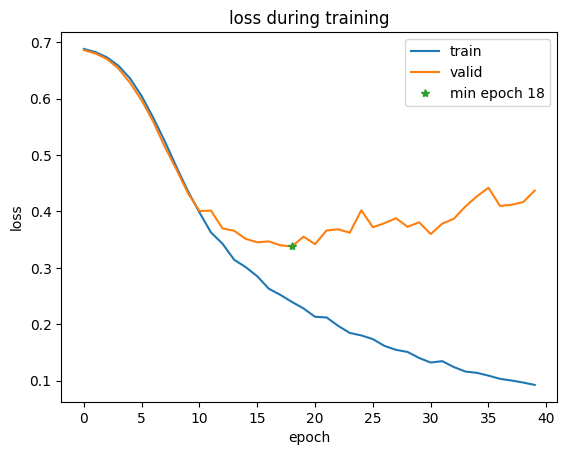

Evaluate on test sets
using BCELOSSwithdigits


Downloading...


total_loss: 0.510
*************** Pgp ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.791  &  0.791  &          0.777  &     0.821  &0.760  &0.798 &0.856 &   0.583 &   0.886

Is a regression task?  False --> Use BCE loss
************************* HIA_Hou *************************


100%|██████████| 40.1k/40.1k [00:00<00:00, 30.6MiB/s]
Loading...
Done!
Cleaning mols: 100%|██████████| 116/116 [00:00<00:00, 407.73it/s]


---> converting SMILES to MACCS...
---> FINISHED
---> converting SMILES to MACCS...
---> FINISHED
---> converting SMILES to MACCS...
---> FINISHED
Epoch 0: [Train] BCE loss: 0.741 [Valid] BCE loss: 0.735
Epoch 5: [Train] BCE loss: 0.579 [Valid] BCE loss: 0.513
Epoch 10: [Train] BCE loss: 0.405 [Valid] BCE loss: 0.335
Epoch 15: [Train] BCE loss: 0.367 [Valid] BCE loss: 0.310
Epoch 20: [Train] BCE loss: 0.314 [Valid] BCE loss: 0.270
Epoch 25: [Train] BCE loss: 0.236 [Valid] BCE loss: 0.219
Epoch 30: [Train] BCE loss: 0.171 [Valid] BCE loss: 0.188
Epoch 35: [Train] BCE loss: 0.137 [Valid] BCE loss: 0.174
Epoch 40: [Train] BCE loss: 0.119 [Valid] BCE loss: 0.187
Epoch 45: [Train] BCE loss: 0.101 [Valid] BCE loss: 0.192
Epoch 50: [Train] BCE loss: 0.091 [Valid] BCE loss: 0.210
Epoch 55: [Train] BCE loss: 0.085 [Valid] BCE loss: 0.232
early stop, no decrease


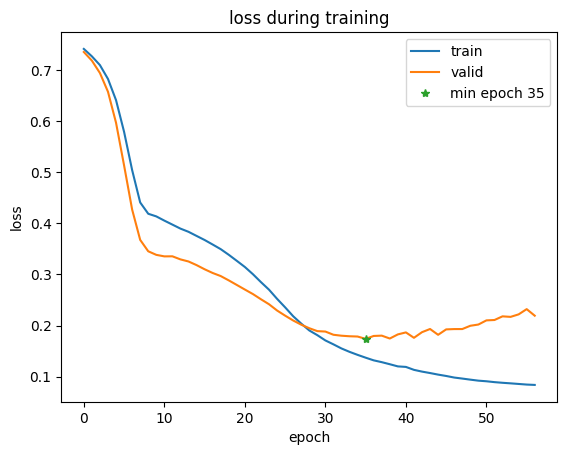

Downloading...


Evaluate on test sets
using BCELOSSwithdigits
total_loss: 0.207
*************** HIA ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.914  &  0.779  &          0.922  &     0.979  &0.579  &0.950 &0.961 &   0.655 &   0.992

Is a regression task?  False --> Use BCE loss
************************* PAMPA_NCATS *************************


100%|██████████| 144k/144k [00:00<00:00, 154kiB/s]
Loading...
Done!
Cleaning mols: 100%|██████████| 407/407 [00:01<00:00, 368.38it/s]


---> converting SMILES to MACCS...
---> FINISHED
---> converting SMILES to MACCS...
---> FINISHED
---> converting SMILES to MACCS...
---> FINISHED
Epoch 0: [Train] BCE loss: 0.672 [Valid] BCE loss: 0.647
Epoch 5: [Train] BCE loss: 0.405 [Valid] BCE loss: 0.426
Epoch 10: [Train] BCE loss: 0.381 [Valid] BCE loss: 0.405
Epoch 15: [Train] BCE loss: 0.353 [Valid] BCE loss: 0.386
Epoch 20: [Train] BCE loss: 0.316 [Valid] BCE loss: 0.382
Epoch 25: [Train] BCE loss: 0.273 [Valid] BCE loss: 0.392
Epoch 30: [Train] BCE loss: 0.225 [Valid] BCE loss: 0.410
Epoch 35: [Train] BCE loss: 0.170 [Valid] BCE loss: 0.455
Epoch 40: [Train] BCE loss: 0.133 [Valid] BCE loss: 0.510
early stop, no decrease


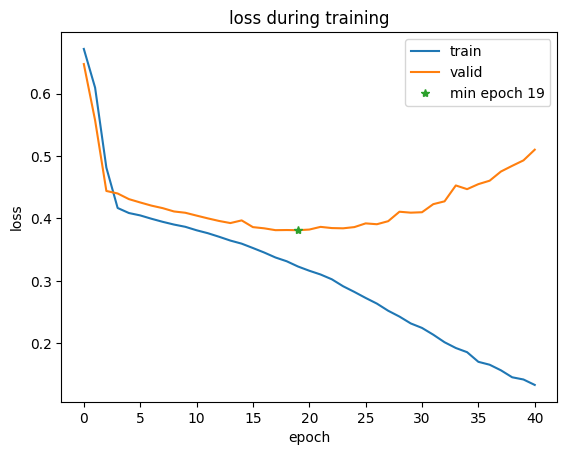

Evaluate on test sets
using BCELOSSwithdigits


Downloading...


total_loss: 0.365
*************** PAMPA ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.850  &  0.522  &          0.851  &     0.997  &0.048  &0.918 &0.767 &   0.164 &   0.941

Is a regression task?  False --> Use BCE loss
************************* CYP2C19_Veith *************************


100%|██████████| 771k/771k [00:00<00:00, 828kiB/s]
Loading...
Done!
Cleaning mols: 100%|██████████| 2533/2533 [00:06<00:00, 377.43it/s]


---> converting SMILES to MACCS...
---> FINISHED
---> converting SMILES to MACCS...
---> FINISHED
---> converting SMILES to MACCS...
---> FINISHED
Epoch 0: [Train] BCE loss: 0.642 [Valid] BCE loss: 0.557
Epoch 5: [Train] BCE loss: 0.466 [Valid] BCE loss: 0.492
Epoch 10: [Train] BCE loss: 0.418 [Valid] BCE loss: 0.472
Epoch 15: [Train] BCE loss: 0.382 [Valid] BCE loss: 0.475
Epoch 20: [Train] BCE loss: 0.332 [Valid] BCE loss: 0.507
Epoch 25: [Train] BCE loss: 0.302 [Valid] BCE loss: 0.520
Epoch 30: [Train] BCE loss: 0.271 [Valid] BCE loss: 0.551
early stop, no decrease


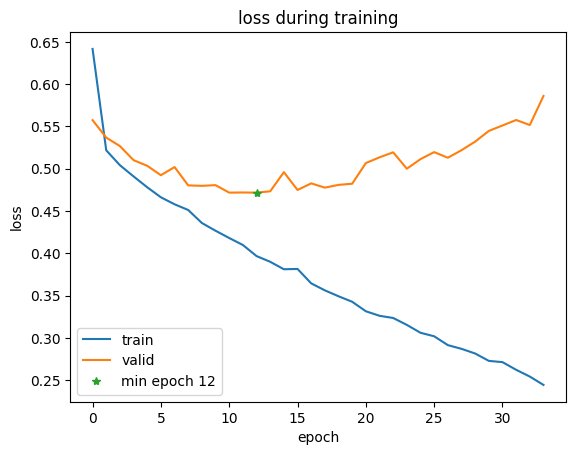

Evaluate on test sets
using BCELOSSwithdigits


Downloading...


total_loss: 0.484
*************** CYP2C19 ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.781  &  0.779  &          0.763  &     0.758  &0.801  &0.760 &0.852 &   0.559 &   0.808

Is a regression task?  False --> Use BCE loss
************************* CYP2D6_Veith *************************


100%|██████████| 800k/800k [00:01<00:00, 714kiB/s]
Loading...
Done!
Cleaning mols: 100%|██████████| 2626/2626 [00:06<00:00, 382.04it/s]


---> converting SMILES to MACCS...
---> FINISHED
---> converting SMILES to MACCS...
---> FINISHED
---> converting SMILES to MACCS...
---> FINISHED
Epoch 0: [Train] BCE loss: 0.529 [Valid] BCE loss: 0.470
Epoch 5: [Train] BCE loss: 0.353 [Valid] BCE loss: 0.367
Epoch 10: [Train] BCE loss: 0.313 [Valid] BCE loss: 0.373
Epoch 15: [Train] BCE loss: 0.277 [Valid] BCE loss: 0.357
Epoch 20: [Train] BCE loss: 0.242 [Valid] BCE loss: 0.377
Epoch 25: [Train] BCE loss: 0.205 [Valid] BCE loss: 0.406
Epoch 30: [Train] BCE loss: 0.175 [Valid] BCE loss: 0.425
Epoch 35: [Train] BCE loss: 0.151 [Valid] BCE loss: 0.539
early stop, no decrease


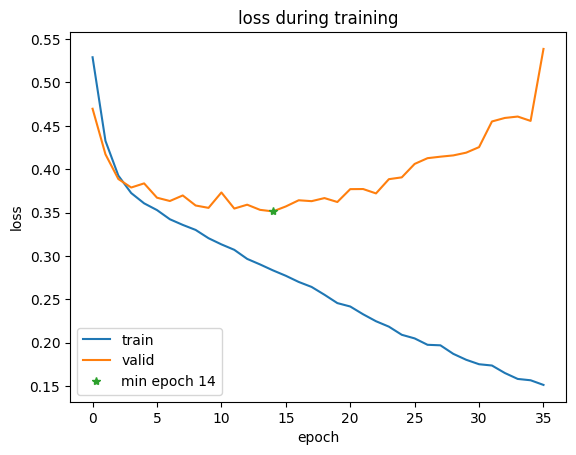

Evaluate on test sets
using BCELOSSwithdigits


Downloading...


total_loss: 0.359
*************** CYP2D6 ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.863  &  0.695  &          0.721  &     0.428  &0.962  &0.537 &0.832 &   0.484 &   0.628

Is a regression task?  False --> Use BCE loss
************************* CYP3A4_Veith *************************


100%|██████████| 746k/746k [00:01<00:00, 662kiB/s]
Loading...
Done!
Cleaning mols: 100%|██████████| 2466/2466 [00:06<00:00, 388.48it/s]


---> converting SMILES to MACCS...
---> FINISHED
---> converting SMILES to MACCS...
---> FINISHED
---> converting SMILES to MACCS...
---> FINISHED
Epoch 0: [Train] BCE loss: 0.669 [Valid] BCE loss: 0.620
Epoch 5: [Train] BCE loss: 0.466 [Valid] BCE loss: 0.484
Epoch 10: [Train] BCE loss: 0.412 [Valid] BCE loss: 0.477
Epoch 15: [Train] BCE loss: 0.363 [Valid] BCE loss: 0.478
Epoch 20: [Train] BCE loss: 0.325 [Valid] BCE loss: 0.491
Epoch 25: [Train] BCE loss: 0.291 [Valid] BCE loss: 0.533
Epoch 30: [Train] BCE loss: 0.247 [Valid] BCE loss: 0.576
early stop, no decrease


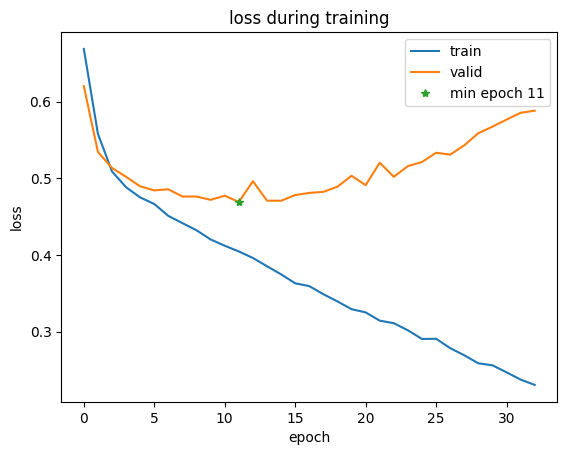

Evaluate on test sets
using BCELOSSwithdigits


Downloading...


total_loss: 0.482
*************** CYP3A4 ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.768  &  0.758  &          0.729  &     0.697  &0.818  &0.713 &0.848 &   0.519 &   0.788

Is a regression task?  False --> Use BCE loss
************************* CYP1A2_Veith *************************


100%|██████████| 760k/760k [00:00<00:00, 851kiB/s]
Loading...
Done!
Cleaning mols: 100%|██████████| 2516/2516 [00:06<00:00, 384.94it/s]


---> converting SMILES to MACCS...
---> FINISHED
---> converting SMILES to MACCS...
---> FINISHED
---> converting SMILES to MACCS...
---> FINISHED
Epoch 0: [Train] BCE loss: 0.628 [Valid] BCE loss: 0.486
Epoch 5: [Train] BCE loss: 0.411 [Valid] BCE loss: 0.428
Epoch 10: [Train] BCE loss: 0.371 [Valid] BCE loss: 0.413
Epoch 15: [Train] BCE loss: 0.325 [Valid] BCE loss: 0.418
Epoch 20: [Train] BCE loss: 0.290 [Valid] BCE loss: 0.423
Epoch 25: [Train] BCE loss: 0.262 [Valid] BCE loss: 0.450
Epoch 30: [Train] BCE loss: 0.231 [Valid] BCE loss: 0.470
early stop, no decrease


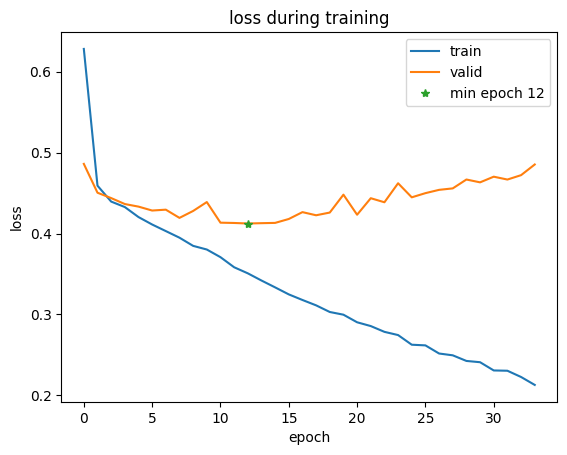

Evaluate on test sets
using BCELOSSwithdigits


Downloading...


total_loss: 0.397
*************** CYP1A2 ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.828  &  0.827  &          0.821  &     0.811  &0.842  &0.816 &0.902 &   0.654 &   0.890

Is a regression task?  False --> Use BCE loss
************************* CYP2C9_Veith *************************


100%|██████████| 740k/740k [00:01<00:00, 609kiB/s]
Loading...
Done!
Cleaning mols: 100%|██████████| 2418/2418 [00:06<00:00, 379.16it/s]


---> converting SMILES to MACCS...
---> FINISHED
---> converting SMILES to MACCS...
---> FINISHED
---> converting SMILES to MACCS...
---> FINISHED
Epoch 0: [Train] BCE loss: 0.652 [Valid] BCE loss: 0.595
Epoch 5: [Train] BCE loss: 0.442 [Valid] BCE loss: 0.471
Epoch 10: [Train] BCE loss: 0.391 [Valid] BCE loss: 0.465
Epoch 15: [Train] BCE loss: 0.335 [Valid] BCE loss: 0.474
Epoch 20: [Train] BCE loss: 0.291 [Valid] BCE loss: 0.489
Epoch 25: [Train] BCE loss: 0.241 [Valid] BCE loss: 0.552
Epoch 30: [Train] BCE loss: 0.199 [Valid] BCE loss: 0.610
early stop, no decrease


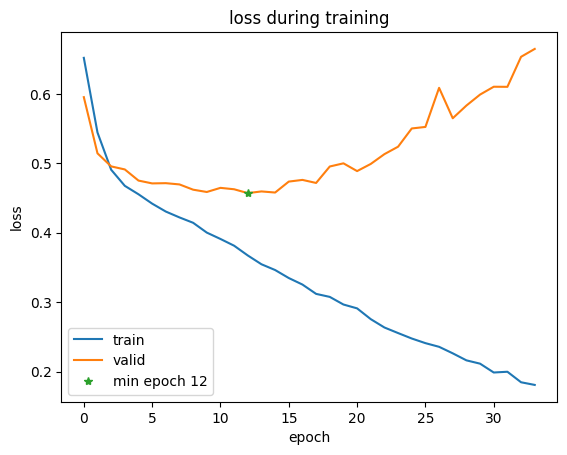

Evaluate on test sets
using BCELOSSwithdigits
total_loss: 0.443
*************** CYP2C9 ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.794  &  0.752  &          0.729  &     0.623  &0.881  &0.671 &0.866 &   0.526 &   0.725



In [63]:
for name in name_reg+name_cls:
    single_train(name)

TOX

Found local copy...
Loading...
Done!


Is a regression task?  True --> Use MSE loss

************************* LD50_Zhu *************************



Cleaning mols: 100%|██████████| 1477/1477 [00:03<00:00, 449.80it/s]


---> converting SMILES to MACCS...
---> FINISHED
---> converting SMILES to MACCS...
---> FINISHED
---> converting SMILES to MACCS...
---> FINISHED
Epoch 0: [Train] MSE loss: 5.697 [Valid] MSE loss: 2.762
Epoch 5: [Train] MSE loss: 0.613 [Valid] MSE loss: 0.653
Epoch 10: [Train] MSE loss: 0.498 [Valid] MSE loss: 0.548
Epoch 15: [Train] MSE loss: 0.456 [Valid] MSE loss: 0.514
Epoch 20: [Train] MSE loss: 0.424 [Valid] MSE loss: 0.488
Epoch 25: [Train] MSE loss: 0.394 [Valid] MSE loss: 0.469
Epoch 30: [Train] MSE loss: 0.368 [Valid] MSE loss: 0.470
Epoch 35: [Train] MSE loss: 0.345 [Valid] MSE loss: 0.466
Epoch 40: [Train] MSE loss: 0.321 [Valid] MSE loss: 0.443
Epoch 45: [Train] MSE loss: 0.303 [Valid] MSE loss: 0.436
Epoch 50: [Train] MSE loss: 0.281 [Valid] MSE loss: 0.441
Epoch 55: [Train] MSE loss: 0.262 [Valid] MSE loss: 0.430
Epoch 60: [Train] MSE loss: 0.242 [Valid] MSE loss: 0.438
Epoch 65: [Train] MSE loss: 0.219 [Valid] MSE loss: 0.437
Epoch 70: [Train] MSE loss: 0.202 [Valid] M

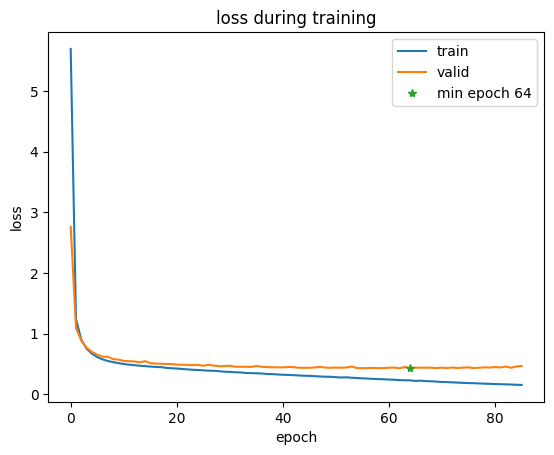

Evaluate on test sets
using MSELoss
total_loss: 0.398
*************** LD50 ***************
MAE     RMSE     R2
& 0.473  & 0.631  & 0.555


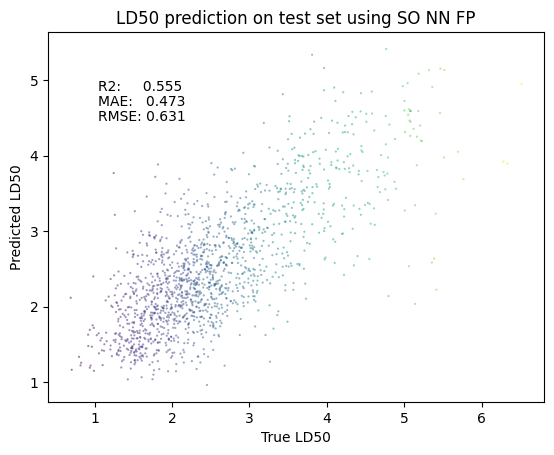

Found local copy...
Loading...
Done!


Is a regression task?  False --> Use BCE loss

************************* hERG_Karim *************************



Cleaning mols: 100%|██████████| 2689/2689 [00:08<00:00, 334.55it/s]


---> converting SMILES to MACCS...
---> FINISHED
---> converting SMILES to MACCS...
---> FINISHED
---> converting SMILES to MACCS...
---> FINISHED
Epoch 0: [Train] BCE loss: 0.674 [Valid] BCE loss: 0.619
Epoch 5: [Train] BCE loss: 0.510 [Valid] BCE loss: 0.529
Epoch 10: [Train] BCE loss: 0.428 [Valid] BCE loss: 0.495
Epoch 15: [Train] BCE loss: 0.380 [Valid] BCE loss: 0.490
Epoch 20: [Train] BCE loss: 0.340 [Valid] BCE loss: 0.511
Epoch 25: [Train] BCE loss: 0.304 [Valid] BCE loss: 0.508
Epoch 30: [Train] BCE loss: 0.277 [Valid] BCE loss: 0.521
Epoch 35: [Train] BCE loss: 0.259 [Valid] BCE loss: 0.520
early stop, no decrease


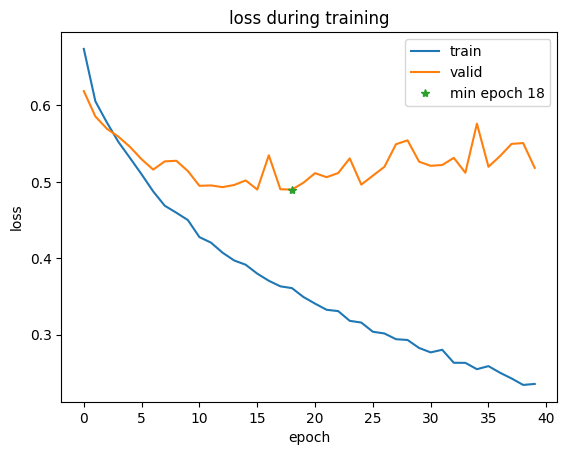

Evaluate on test sets
using BCELOSSwithdigits


Found local copy...
Loading...
Done!


total_loss: 0.484
*************** hERG ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.785  &  0.785  &          0.785  &     0.783  &0.786  &0.784 &0.858 &   0.569 &   0.863

Is a regression task?  False --> Use BCE loss

************************* AMES *************************



Cleaning mols: 100%|██████████| 1456/1456 [00:03<00:00, 438.47it/s]


---> converting SMILES to MACCS...
---> FINISHED
---> converting SMILES to MACCS...
---> FINISHED
---> converting SMILES to MACCS...
---> FINISHED
Epoch 0: [Train] BCE loss: 0.690 [Valid] BCE loss: 0.669
Epoch 5: [Train] BCE loss: 0.475 [Valid] BCE loss: 0.497
Epoch 10: [Train] BCE loss: 0.397 [Valid] BCE loss: 0.478
Epoch 15: [Train] BCE loss: 0.339 [Valid] BCE loss: 0.518
Epoch 20: [Train] BCE loss: 0.283 [Valid] BCE loss: 0.520
Epoch 25: [Train] BCE loss: 0.239 [Valid] BCE loss: 0.545
Epoch 30: [Train] BCE loss: 0.202 [Valid] BCE loss: 0.580
early stop, no decrease


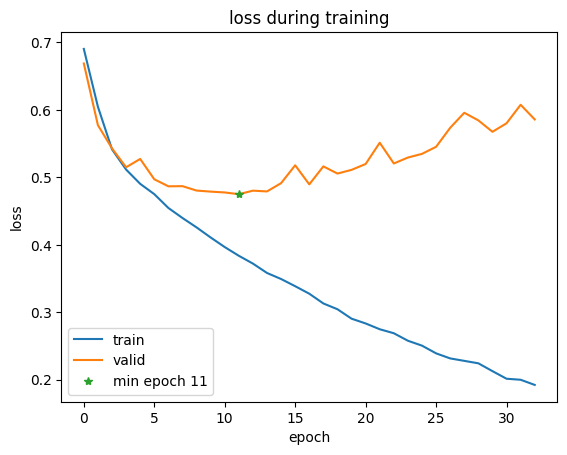

Evaluate on test sets
using BCELOSSwithdigits
total_loss: 0.456
*************** AMES ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.815  &  0.809  &          0.810  &     0.865  &0.754  &0.836 &0.870 &   0.625 &   0.879



In [36]:
for name in ['LD50_Zhu', 'hERG_Karim', 'AMES']:
    single_train(name)

Found local copy...
Loading...
Done!


******************** LD50_Zhu ********************


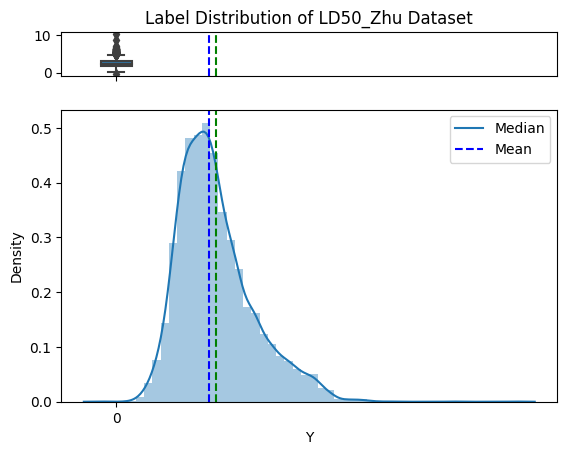

Downloading...


******************** hERG_at_1uM ********************


100%|██████████| 23.6M/23.6M [00:02<00:00, 9.15MiB/s]
Loading...
Done!


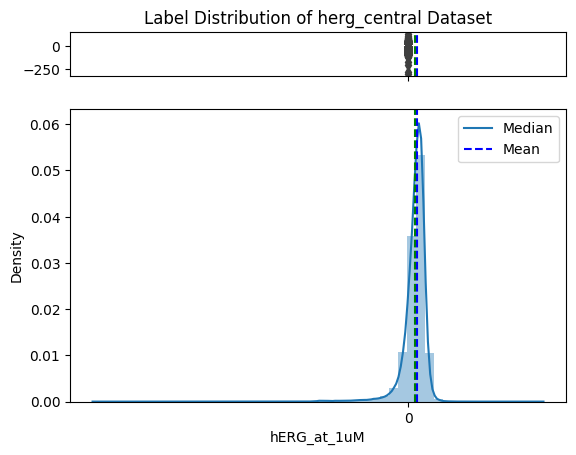

Found local copy...
Loading...


******************** hERG_at_10uM ********************


Done!


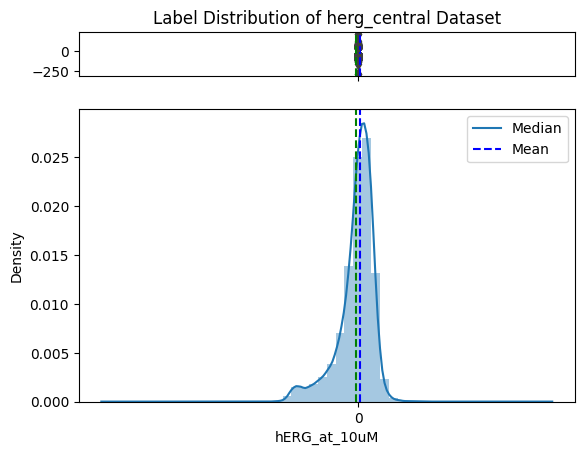

Downloading...


******************** hERG ********************


100%|██████████| 50.2k/50.2k [00:00<00:00, 275kiB/s]
Loading...
Done!


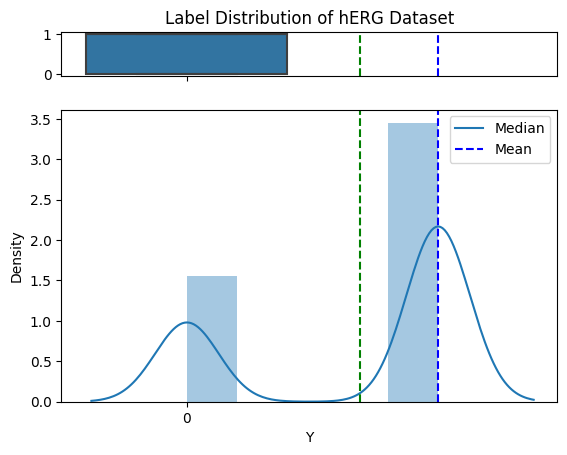

Downloading...


******************** hERG_Karim ********************


100%|██████████| 885k/885k [00:01<00:00, 807kiB/s] 
Loading...
Done!


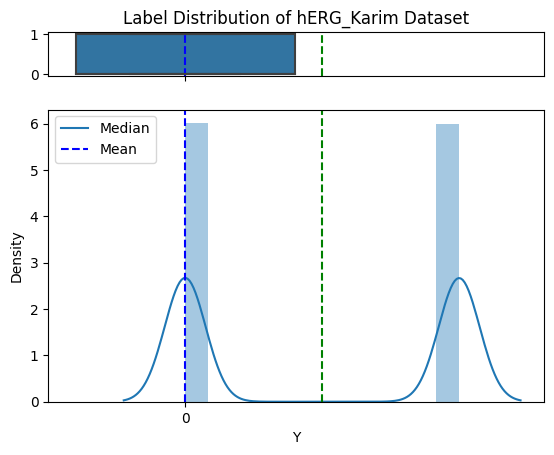

Downloading...


******************** AMES ********************


100%|██████████| 344k/344k [00:00<00:00, 627kiB/s]
Loading...
Done!


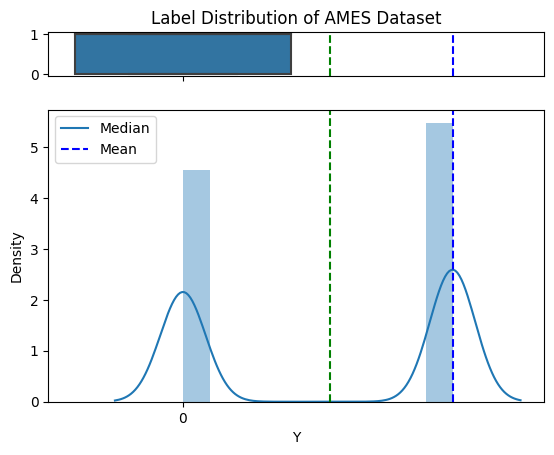

Found local copy...
Loading...


******************** hERG_inhib ********************


Done!


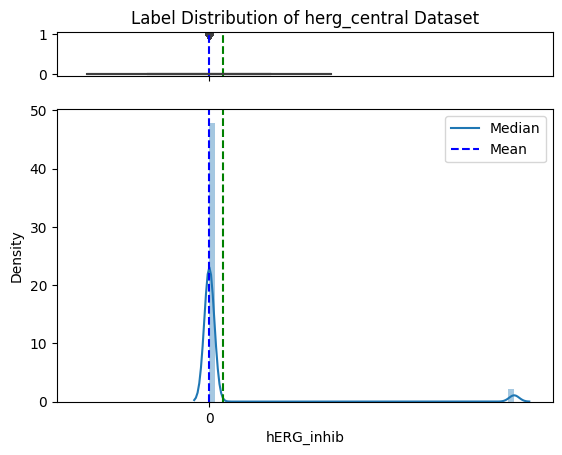